In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose

class ImageDataset(Dataset):
    def __init__(self, image_dir, image_dir_2, transform=None):
        self.image_dir = image_dir
        self.image_dir_2 = image_dir_2
        self.image_files = [i for i in os.listdir(image_dir) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.images_files_2 = [i for i in os.listdir(image_dir_2) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.transform = transform
 
    def len(self):
        return len(self.image_files)

    def getItem(self, dirc, files, idx):
        img_path = os.path.join(dirc, files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image  
    
    def getDataset(self, limit):
        total_dataset = []
        for i in range(1, limit):
            if i % 1000 == 0:
                print(f"Have reached {i}/{len(self.image_files)}")
            total_dataset.append([self.getItem(dirc =self.image_dir, files=self.image_files, idx=i), self.getItem(dirc =self.image_dir_2, files=self.images_files_2, idx=i)])
        return total_dataset
    
    def getImage(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image_1 = Image.open(img_path).convert("L")
        img_path_2 = os.path.join(self.image_dir_2, self.images_files_2[idx])
        image_2 = Image.open(img_path_2).convert("L")
        if self.transform:
            image_1 = self.transform(image_1)
            image_2 = self.transform(image_2)
        return [image_1, image_2]
        

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()
clean_dir = os.environ["DATA_DIR"]
noise_dir = os.environ['DATA_DIR_2']
clean_dir_t = os.environ["DATA_DIR_T"]
noise_dir_t = os.environ['DATA_DIR_T_2']

In [5]:
transformations = Compose([
    ToTensor(), 
])

train_dataset = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(10001)
test_dataset = ImageDataset(image_dir=clean_dir_t, image_dir_2=noise_dir_t, transform=transformations).getDataset(2001)

Have reached 1000/12189
Have reached 2000/12189
Have reached 3000/12189
Have reached 4000/12189
Have reached 5000/12189
Have reached 6000/12189
Have reached 7000/12189
Have reached 8000/12189
Have reached 9000/12189
Have reached 10000/12189
Have reached 1000/2621
Have reached 2000/2621


In [6]:
len(train_dataset)

10000

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
len(train_dataloader)

625

In [9]:
train_image_batches, train_target_batches = next(iter(train_dataloader))

In [10]:
train_image_batches.shape, train_target_batches.shape

(torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256]))

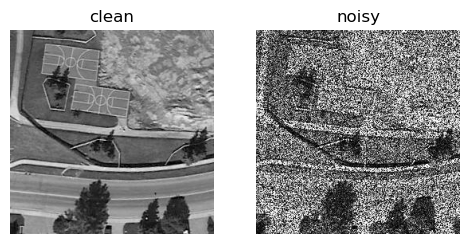

In [11]:
import matplotlib.pyplot as plt

rand = torch.randint(low=1, high=BATCH_SIZE, size=(1,)).item()
test_image = train_image_batches[rand]
test_target = train_target_batches[rand]

plt.figure(figsize=(9,9))
plt.subplot(3,3, 1)
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title('clean')
plt.axis(False)
plt.subplot(3,3,2)
plt.imshow(test_target.squeeze(), cmap='gray')
plt.title('noisy')
plt.axis(False)
plt.show()

In [12]:
# this is the cell that creates the model so make sure you run this like 
# for real, this is no joke

class SARDespeckleModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.initial_stack = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.middle_stack = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(num_features=hidden_units),
                    nn.ReLU()
                )
                for _ in range(6)
            ]
        )
        self.final_stack = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
    
        self.tanh_layer = nn.Tanh()

    def forward(self, initial:torch.Tensor):
        x = self.initial_stack(initial)
        x = self.middle_stack(x)
        res = self.final_stack(x)
        despeckle = initial/(res + 1e-8)
        img = self.tanh_layer(despeckle)
        return img

In [13]:
model0 = SARDespeckleModel(
    input_shape=1,
    hidden_units=64,
    output_shape=1,
)

# ks = [32, 64, 128]
# models = [[SARDespeckleModel(1, 64, 1) for x in range(256**2 / k**2)] for k in ks]

In [14]:
def total_variation_loss(img, weight):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
    return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

def loss_fn(predicted, target):
    mse_loss = nn.MSELoss()
    L_E = mse_loss(predicted, target) 
    L_TV = total_variation_loss(predicted, .002)
    loss = L_E +  L_TV
    return loss

optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.0002)

In [15]:
from tqdm.auto import tqdm

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
    total_loss =0
    model0.to(device)
    model0.train()
    for batch, (clean_img, noise_img) in enumerate(train_dataloader):

        clean_img, noise_img = clean_img.to(device), noise_img.to(device)
        img_pred = model0(noise_img)
        loss = loss_fn(img_pred, clean_img)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if batch % 400 ==0:
            print(f"We have passed {batch * len(clean_img)}/{len(train_dataloader.dataset)} samples")
            print(f'Current Accumalting Total Loss: {total_loss:.6f} | Current Loss: {loss} \n---------')
    
    total_loss /= len(train_dataloader)
    print(f"So far our train loss has been: {total_loss:.3f}")



  0%|          | 0/3 [00:00<?, ?it/s]

We have passed 0/10000 samples
Current Accumalting Total Loss: 0.278007 | Current Loss: 0.2780069410800934 
---------
We have passed 6400/10000 samples
Current Accumalting Total Loss: 9.383398 | Current Loss: 0.016274115070700645 
---------
So far our train loss has been: 0.021
We have passed 0/10000 samples
Current Accumalting Total Loss: 0.013165 | Current Loss: 0.013164769858121872 
---------
We have passed 6400/10000 samples
Current Accumalting Total Loss: 6.258931 | Current Loss: 0.01328678335994482 
---------
So far our train loss has been: 0.015
We have passed 0/10000 samples
Current Accumalting Total Loss: 0.011481 | Current Loss: 0.01148119755089283 
---------
We have passed 6400/10000 samples
Current Accumalting Total Loss: 5.958216 | Current Loss: 0.006595350336283445 
---------
So far our train loss has been: 0.015


In [16]:
model0.eval()
test_loss = 0
before_int = 0
test_img_pred = 0
test_img_label = 0
with torch.inference_mode():
    for (y, X) in test_dataloader:
        y, X = y.to(device), X.to(device)
        img_pred = model0(X)
        test_loss += loss_fn(img_pred, y)
        before_int = X
        test_img_pred = img_pred
        test_img_label = y

    test_loss /= len(test_dataloader)

print(f'Test loss: {test_loss}')

Test loss: 0.013238362967967987


In [27]:
test_img_pred_sample, test_img_label_sample = test_img_pred[-1].to('cpu'), test_img_label[-1].to('cpu')
original = before_int[0].to('cpu')

In [30]:
test_img_pred_sample.shape

torch.Size([1, 256, 256])

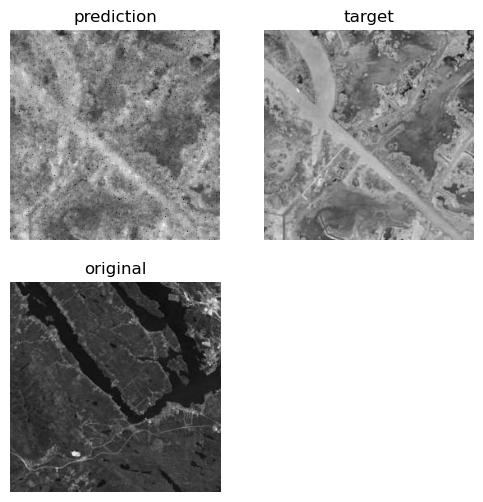

In [29]:
plt.figure(figsize=(6,6))

def plot_cm(test, pred, og):
    plt.subplot(2,2, 1)
    plt.imshow(test.squeeze(), cmap='gray')
    plt.title('prediction')
    plt.axis(False)

    plt.subplot(2,2,2)
    plt.imshow(pred.squeeze(), cmap='gray')
    plt.title('target')
    plt.axis(False)

    plt.subplot(2,2,3)
    plt.imshow(og.squeeze(), cmap='gray')
    plt.title('original')
    plt.axis(False)
    plt.show()

plot_cm(test_img_pred_sample, test_img_label_sample, original)

In [19]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
psnr = PeakSignalNoiseRatio()
ssim = StructuralSimilarityIndexMeasure()

print(f"PSRN (higher the better): {psnr(test_img_pred_sample, test_img_label_sample)}") 
print(f"SSIM (0-1 scale): {ssim(test_img_pred.to('cpu'), test_img_label.to('cpu'))}") 

PSRN (higher the better): 33.724365234375
SSIM (0-1 scale): 0.7790207266807556


In [20]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'sar_model'
MODEL_SAVE_PATH = MODEL_PATH/ MODEL_NAME   

print(f'saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

saving model to models\sar_model


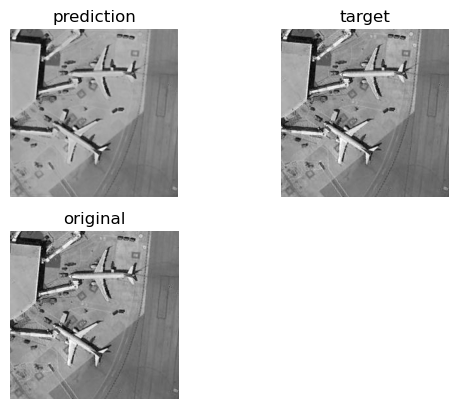

Prediction Image PSNR (higher the better): 27.863 vs Original Noisy PSRN: inf
Predicction Image SSIM (0-1 scale): 0.907 vs Oringal Noisy SSIM: 1.000


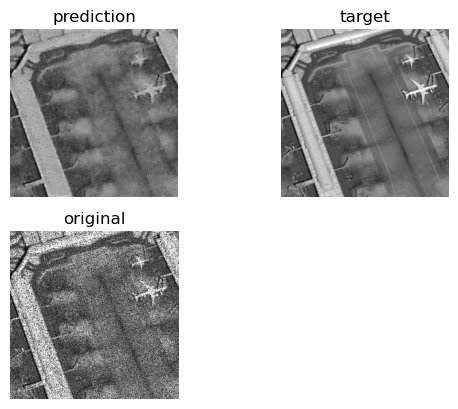

Prediction Image PSNR (higher the better): 23.545 vs Original Noisy PSRN: 16.615
Predicction Image SSIM (0-1 scale): 0.610 vs Oringal Noisy SSIM: 0.228


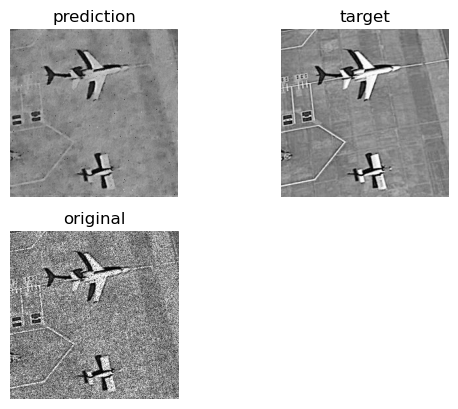

Prediction Image PSNR (higher the better): 23.043 vs Original Noisy PSRN: 15.371
Predicction Image SSIM (0-1 scale): 0.548 vs Oringal Noisy SSIM: 0.198


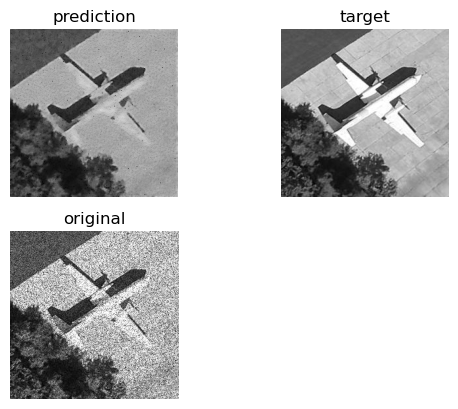

Prediction Image PSNR (higher the better): 20.331 vs Original Noisy PSRN: 15.404
Predicction Image SSIM (0-1 scale): 0.564 vs Oringal Noisy SSIM: 0.269


In [21]:
model0.eval()
sample_dataset = train_dataset = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations)
pred_imgs = []
with torch.inference_mode():
    for i in range(69, 73):
        original, noise_sample = sample_dataset.getImage(idx=i)
        input_img = noise_sample.to(device).unsqueeze(dim=0)
        pred = model0(input_img)
        pred = pred[0].to('cpu')
        plot_cm(pred, original, noise_sample)
        print(f"Prediction Image PSNR (higher the better): {psnr(pred, original):.3f} vs Original Noisy PSRN: {psnr(noise_sample, original):.3f}") 
        print(f"Predicction Image SSIM (0-1 scale): {ssim(pred.unsqueeze(dim=0), original.unsqueeze(dim=0)):.3f} vs Oringal Noisy SSIM: {ssim(noise_sample.unsqueeze(dim=0), original.unsqueeze(dim=0)):.3f}")   
